# 3. Get Depth Map

## Objective
- 1 : Generate Depth map

- 2 : Reconstruction 3D point cloud 

## Steps
1. Capture charuco board images with mono fish-eye camera
2. Get matching points with world space and image space
3. Estimate camera parameters(K, D), and camera pose matrix(R_list, t_list).
4. Estimate new camera parameter(K) to undistort images
5. Calculate rectification map
6. Create distortion-free images

## Data
- I used KITTI dataset.

In [1]:
from glob import glob
import numpy as np
import sys, os, cv2, inspect
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
from ipywidgets import interact, interactive, fixed



# Load and Reload : stereo_camera_utility.py
import importlib
import stereo_camera_utility
importlib.reload(stereo_camera_utility)

from stereo_camera_utility import getStereoRectifiedImage, drawEpipolarLines

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Files of KITTI dataset (2011_09_30)
- Data of 'xxx_sync' directories are already calibrated (rectifed).
- Data of 'xxx_extranted' directories are not calibrated.
- Here, we use calibrated data to get **Depth Map** .

To download KITTI dataset, run the code below.
```bash
# calibration parameters
target="2011_09_30_calib.zip"
shortname="${target}"
fullname="${target}"
wget "https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/${fullname}"
unzip -o ${shortname}

# calibrated data
target=2011_09_30_drive_0016
shortname="${target}_sync.zip"
fullname="${target}/${target}_sync.zip"
wget "https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/${fullname}"
unzip -o ${shortname}

```


- calib_***.txt : camera calibration parameters
- ***_sync/image_00 : **gray** scale images of the **Left** camera
- ***_sync/image_01 : **gray** scale images of the **Right** camera
- ***_sync/image_02 : **rgb** scale images of the **Left** camera
- ***_sync/image_03 : **rgb** scale images of the **Right** camera

Here, we use RGB images

In [2]:
!ls -lh /kaggle/input/KITTI/raw_data/2011_09_30/2011_09_30_drive_0016_sync

total 24K
drwxrwxr-x 3 takuya takuya 4.0K May 23  2012 image_00
drwxrwxr-x 3 takuya takuya 4.0K May 23  2012 image_01
drwxrwxr-x 3 takuya takuya 4.0K May 23  2012 image_02
drwxrwxr-x 3 takuya takuya 4.0K May 23  2012 image_03
drwxrwxr-x 3 takuya takuya 4.0K May 23  2012 oxts
drwxrwxr-x 3 takuya takuya 4.0K May 23  2012 velodyne_points


In [3]:
!ls -lh /kaggle/input/KITTI/object/training/

total 956K
drwxrwxr-x 2 takuya takuya 224K Jun  1  2012 calib
drwxrwxr-x 2 takuya takuya 236K Jun  1  2012 image_2
drwxrwxr-x 2 takuya takuya 256K Jun  1  2012 image_3
drwxrwxr-x 2 takuya takuya 224K May 21  2015 label_2


In [4]:
# raw_data
top_dir = '/kaggle/input/KITTI/raw_data/2011_09_30/2011_09_30_drive_0016_sync'
file_paths_img_left = sorted(glob(f'{top_dir}/image_02/data/*.png'))
file_paths_img_right = sorted(glob(f'{top_dir}/image_03/data/*.png'))

# object
top_dir = '/kaggle/input/KITTI/object/training'
file_paths_img_left = sorted(glob(f'{top_dir}/image_2/*.png'))
file_paths_img_right = sorted(glob(f'{top_dir}/image_3/*.png'))

print(f'image_num_left = {len(file_paths_img_left)}')
print(f'image_num_right = {len(file_paths_img_right)}')

image_num_left = 7481
image_num_right = 7481


## Visualize left and right images
- These images are already rectified.

file_ids = [3155, 6209, 6917]


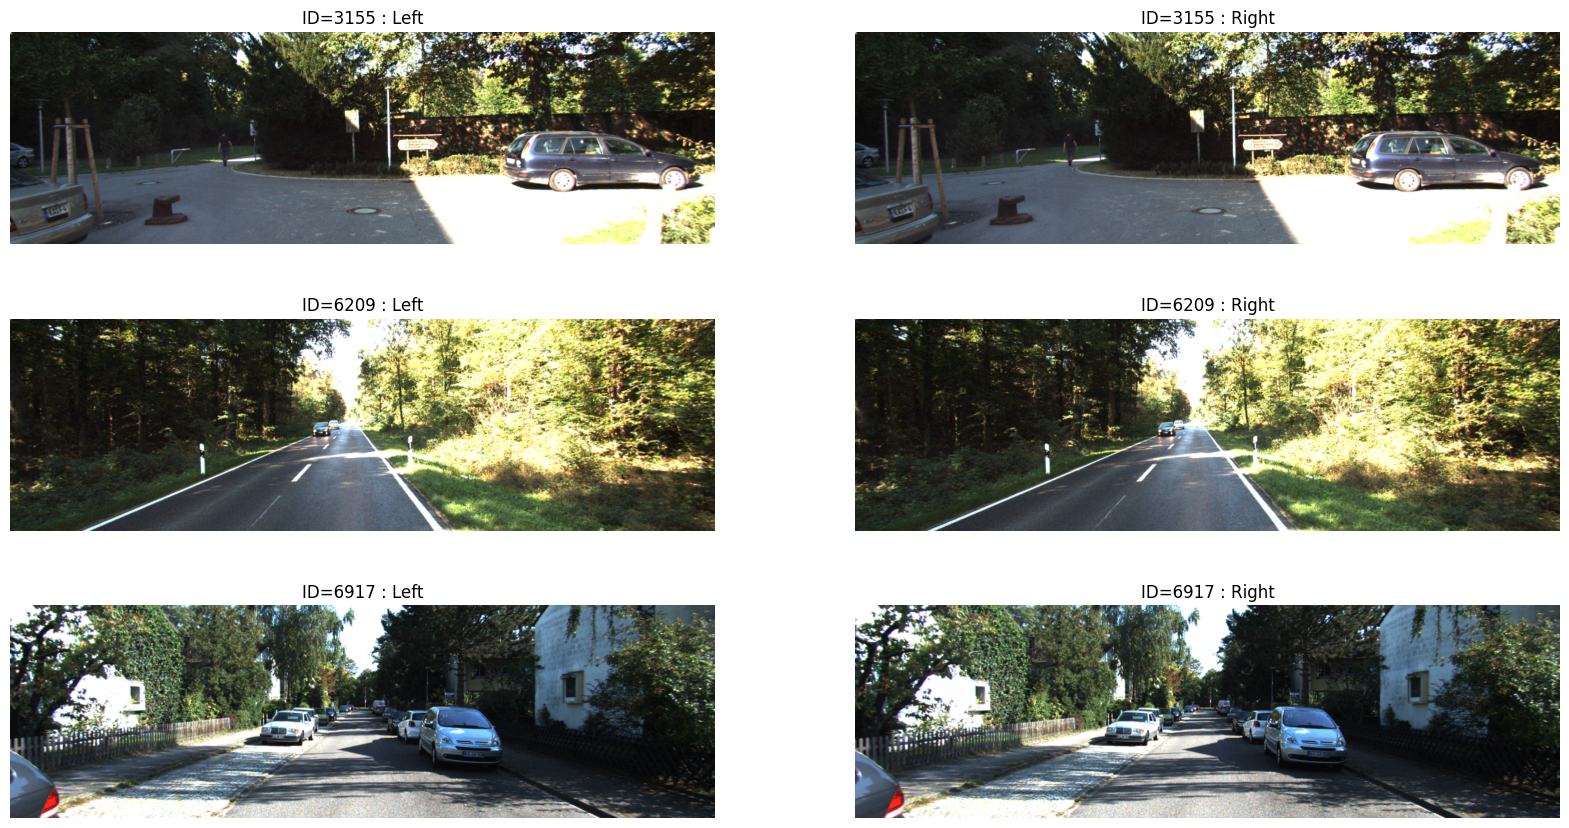

In [5]:
import random
random.seed(0)
image_num = 3
file_ids = sorted(random.sample(range(0, len(file_paths_img_left)-1), image_num))

print(f'file_ids = {file_ids}')

plt.figure(figsize=(20,18))

for i, file_id in enumerate(file_ids):    
    # laod image
    img_left = cv2.imread(file_paths_img_left[file_id])
    img_right = cv2.imread(file_paths_img_right[file_id])
    
    # transform bgr to rgb
    img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
    img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)
    
    # show images
    plt.subplot(5,2,2*i+1)
    plt.imshow(img_left)
    plt.title(f'ID={file_id} : Left')
    plt.axis('off')
    
    plt.subplot(5,2,2*i+2)
    plt.imshow(img_left)
    plt.title(f'ID={file_id} : Right')
    plt.grid()
    plt.axis('off')
    

## Read KITTI calibration data

1. Projection Matrix : P0, P1, P2, P3
    - 

$
[ fu   0   cu   Tx ]
[  0  fv   cv   Ty ]
[  0   0    1   Tz ]

$

In [6]:
def printDict(dict):
    for key, value in dict.items():
        print(f'\n{key} = ')
        print(f'{value}')

In [7]:
from stereo_camera_utility import readObjectCalibFile
calib_params = readObjectCalibFile(f'{top_dir}/calib/000000.txt')
printDict(calib_params)


P0 = 
[[707.0493   0.     604.0814   0.    ]
 [  0.     707.0493 180.5066   0.    ]
 [  0.       0.       1.       0.    ]]

P1 = 
[[ 707.0493    0.      604.0814 -379.7842]
 [   0.      707.0493  180.5066    0.    ]
 [   0.        0.        1.        0.    ]]

P2 = 
[[ 7.070493e+02  0.000000e+00  6.040814e+02  4.575831e+01]
 [ 0.000000e+00  7.070493e+02  1.805066e+02 -3.454157e-01]
 [ 0.000000e+00  0.000000e+00  1.000000e+00  4.981016e-03]]

P3 = 
[[ 7.070493e+02  0.000000e+00  6.040814e+02 -3.341081e+02]
 [ 0.000000e+00  7.070493e+02  1.805066e+02  2.330660e+00]
 [ 0.000000e+00  0.000000e+00  1.000000e+00  3.201153e-03]]

R0_rect = 
[[ 0.9999128   0.01009263 -0.00851193]
 [-0.01012729  0.9999406  -0.00403767]
 [ 0.00847068  0.00412352  0.9999556 ]]

Tr_velo_to_cam = 
[[ 0.00692796 -0.9999722  -0.00275783 -0.02457729]
 [-0.00116298  0.00274984 -0.9999955  -0.06127237]
 [ 0.9999753   0.00693114 -0.0011439  -0.3321029 ]]

Tr_imu_to_velo = 
[[ 9.999976e-01  7.553071e-04 -2.035826e-03 -8

In [8]:
K_left, R_left, t_left, _, _, _, _ = cv2.decomposeProjectionMatrix(calib_params['P2'])
t_left /= t_left[3]
print(f'K_left = \n{K_left}\n')
print(f'R_left = \n{R_left}\n')
print(f't_left = \n{t_left}\n')

K_left = 
[[707.0493   0.     604.0814]
 [  0.     707.0493 180.5066]
 [  0.       0.       1.    ]]

R_left = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

t_left = 
[[-0.06046166]
 [ 0.00176016]
 [-0.00498102]
 [ 1.        ]]



In [9]:
K_right, R_right, t_right, _, _, _, _ = cv2.decomposeProjectionMatrix(calib_params['P3'])
t_right /= t_right[3]
print(f'K_right = \n{K_right}\n')
print(f'R_right = \n{R_right}\n')
print(f't_right = \n{t_right}\n')

K_right = 
[[707.0493   0.     604.0814]
 [  0.     707.0493 180.5066]
 [  0.       0.       1.    ]]

R_right = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

t_right = 
[[ 0.47527359]
 [-0.00247908]
 [-0.00320115]
 [ 1.        ]]



In [10]:
t_rel = t_right - t_left
t_rel = t_rel.flatten()
print(f't_rel = {t_rel}')

T_x = np.array([
    [0, -t_rel[2], t_rel[1]],
    [t_rel[2], 0, -t_rel[0]],
    [-t_rel[1], t_rel[0], 0]
])

F = np.linalg.inv(K_right).T @ T_x @ R_right @ np.linalg.inv(K_left)
print(f'F = {F}')


t_rel = [ 0.53573524 -0.00423924  0.00177986  0.        ]
F = [[ 0.00000000e+00 -3.56030482e-09 -5.35302167e-06]
 [ 3.56030482e-09  0.00000000e+00 -7.59856353e-04]
 [ 5.35302167e-06  7.59856353e-04  0.00000000e+00]]


line: ax+by+c = 0 // average of -a/b = -0.00742


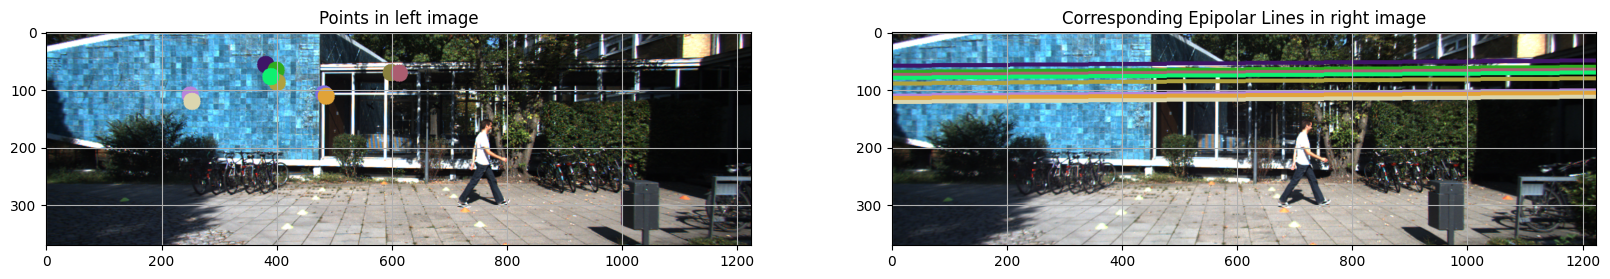

In [11]:
file_id = 0
img_left_bgr = cv2.imread(file_paths_img_left[file_id])
img_right_bgr = cv2.imread(file_paths_img_right[file_id])

img_left_rgb = cv2.cvtColor(img_left_bgr, cv2.COLOR_BGR2RGB)
img_right_rgb = cv2.cvtColor(img_right_bgr, cv2.COLOR_BGR2RGB)

drawEpipolarLines(img_right_bgr.copy(), img_left_bgr.copy(), F, top_k=10)

line: ax+by+c = 0 // average of -a/b = -0.00714


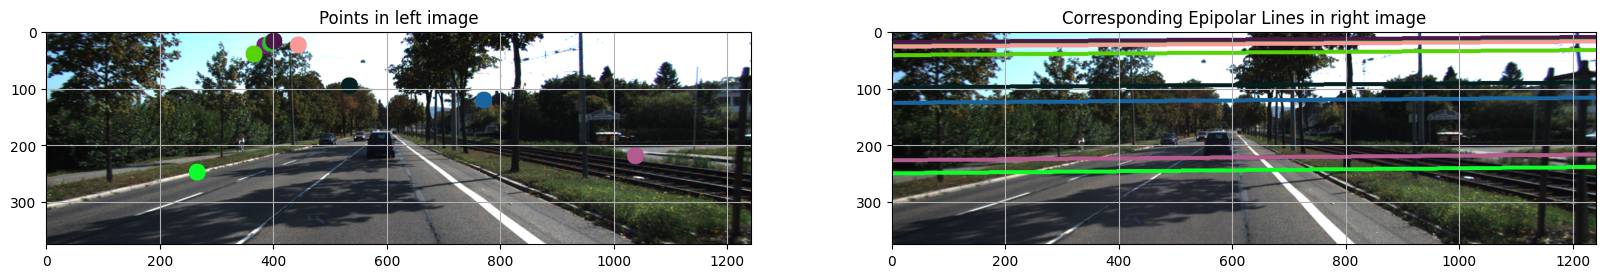

In [12]:
file_id = 7
img_left_bgr = cv2.imread(file_paths_img_left[file_id])
img_right_bgr = cv2.imread(file_paths_img_right[file_id])

img_left_rgb = cv2.cvtColor(img_left_bgr, cv2.COLOR_BGR2RGB)
img_right_rgb = cv2.cvtColor(img_right_bgr, cv2.COLOR_BGR2RGB)

drawEpipolarLines(img_right_bgr.copy(), img_left_bgr.copy(), F, top_k=10)

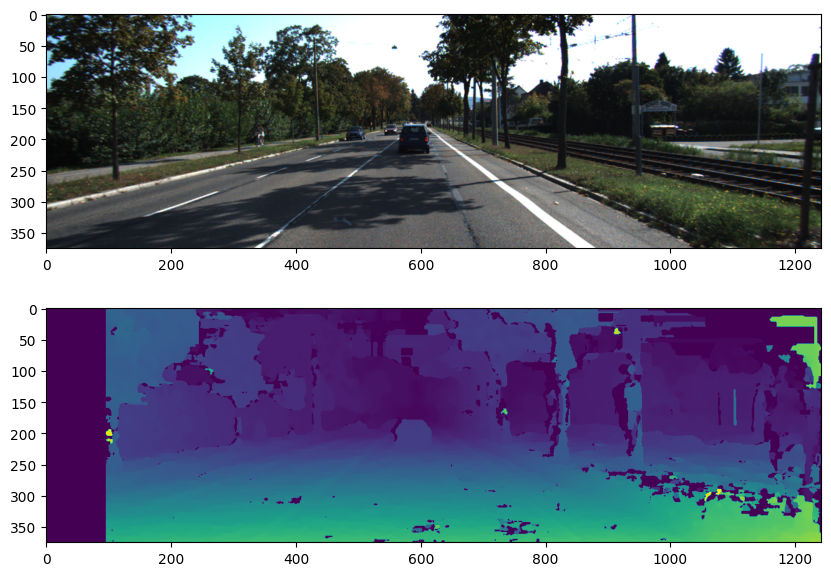

In [13]:
from stereo_camera_utility import calcDisparity

disparity_map = calcDisparity(img_left_bgr, 
                              img_right_bgr, 
                              matcher="stereo_sgbm", 
                              num_disparities=6*16,  # 16*13, 
                              block_size=11,  # 9, 
                              window_size=6  # 9
                              )

plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.imshow(img_left_rgb)

plt.subplot(2,1,2)
plt.imshow(disparity_map)

# Calculate Depth Map

$
Z = \frac{f \cdot b}{x_L - x_R} = \frac{f \cdot b}{disparity}
$

In [14]:
def calcDepthMap(disparity_left, K_left, t_left, t_right):
    # focal length
    f = K_left[0,0]
    
    # baseline
    b = abs(t_left[0] - t_right[0])
    
    # Replace all instances of 0 and -1 disparity with a small minimum value (to avoid div by 0 or negatives)
    disparity_left[disparity_left==0] = 0.1
    disparity_left[disparity_left==-1] = 0.1
    
    # Initialize the depth map to match the size of the disparity map
    depth_map = np.ones(disparity_left.shape, np.single)
    
    # Calculate disparity map
    depth_map[:] = f * b / disparity_map[:]
    
    return depth_map

Text(0.5, 1.0, 'Depth Map')

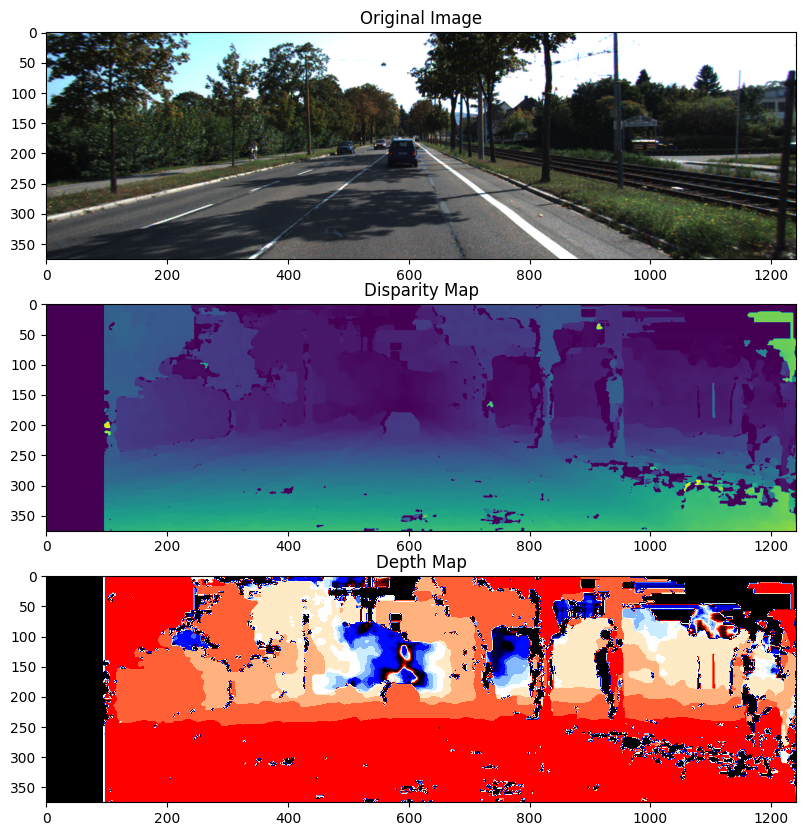

In [15]:
depth_map_left = calcDepthMap(disparity_map, K_left, t_left, t_right)

fig, axes = plt.subplots(3,1, figsize=(10,10))

axes[0].imshow(img_left_rgb)
axes[0].set_title('Original Image')

axes[1].imshow(disparity_map)
axes[1].set_title('Disparity Map')

axes[2].imshow(depth_map_left, cmap='flag')
axes[2].set_title('Depth Map')

# Find the Bounding Boxes

In [16]:
#!sudo pip install ultralytics #packages installed for me: ultralytics-8.3.51 ultralytics-thop-2.0.13

In [17]:
#!wget https://stereo-vision.s3.eu-west-3.amazonaws.com/yolo11n.pt  #download yolo11n.pt
#!mv ./yolo11n.pt ./data/models/

In [18]:
import ultralytics
from ultralytics import YOLO
import time
import torch

# load a model
model = YOLO('./data/models/yolo11n.pt')

print(model.overrides) 
print("Ultralytics version:", ultralytics.__version__)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/takuya/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
{'task': 'detect', 'data': '/usr/src/ultralytics/ultralytics/cfg/datasets/coco.yaml', 'imgsz': 640, 'single_cls': False, 'model': './data/models/yolo11n.pt'}
Ultralytics version: 8.3.171


In [19]:

# Try using GPU
try:
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model.to(device)
except RuntimeError as e:
    device = 'cpu'
    model.to(device)
finally:
    print(f'device = {device}')

device = cuda:0


In [20]:
def detectObstacles(img, model, device):
    h, w, _ = img.shape
    results = model.predict(img, device=device)
    result = results[0]  # get prediction result for the first image.
    boxes = result.boxes  # Boxes object for bounding box outputs
    # masks = result.masks  # Masks object for segmentation masks outputs
    # keypoints = result.keypoints  # Keypoints object for pose outputs
    # probs = result.probs  # Probs object for classification outputs
    # obb = result.obb # Oriented boxes object for OBB outputs
    
    # Get person or car
    boxes_filter = []
    for box in boxes:
        object_type = result.names[int(box.cls[0])]
        if object_type=='person' or object_type=='car':
            boxes_filter.append(True)
        else:
            boxes_filter.append(False)
            
    pred_classes = []
    for label in boxes.cls[boxes_filter]:
        pred_classes.append(result.names[int(label)])
        
    # xywhn: 各バウンディングボックスを [center_x, center_y, width, height] 形式で 
    # 画像サイズで割った正規化値として返します
    pred_bboxes = boxes.xywhn[boxes_filter]
    pred_bboxes[:, 0] *= w # ratio to pixel
    pred_bboxes[:, 1] *= h # ratio to pixel
    pred_bboxes[:, 2] *= w # ratio to pixel
    pred_bboxes[:, 3] *= h # ratio to pixel
    pred_conf = boxes.conf[boxes_filter]
    return pred_bboxes, pred_classes, pred_conf

print(f'img_left_rgb.shape = {img_left_rgb.shape}')

pred_bboxes, pred_classes, pred_conf = detectObstacles(img_left_bgr, model, device)

img_left_rgb.shape = (375, 1242, 3)



0: 224x640 3 cars, 115.5ms
Speed: 7.0ms preprocess, 115.5ms inference, 316.1ms postprocess per image at shape (1, 3, 224, 640)


In [21]:
print(f'pred_bboxes = \n{pred_bboxes}\n')
print(f'pred_classes = \n{pred_classes}\n')
print(f'pred_conf = \n{pred_conf}\n')


pred_bboxes = 
tensor([[589.9032, 197.7618,  50.3762,  50.2707],
        [553.4805, 184.4307,  25.5198,  18.8808],
        [497.2751, 192.1904,  31.1200,  21.1193]], device='cuda:0')

pred_classes = 
['car', 'car', 'car']

pred_conf = 
tensor([0.5979, 0.5801, 0.4626], device='cuda:0')



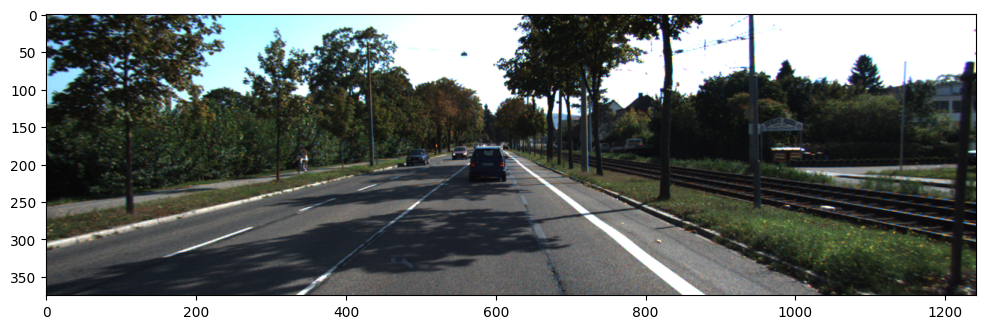

In [22]:
def drawDetectedObstacles(pred_bboxes, pred_classes, pred_conf, img_ori):
    rectangle_thickness = 3
    text_thickness = 3
    img = img_ori.copy()
    h, w, _ = img.shape
    counter = 0
    for box, cls, conf in zip(pred_bboxes, pred_classes, pred_conf):
        x1 = int(box[0]*w - box[2]*w*0.5) # left : center_x - width /2
        y1 = int(box[1]*h-box[3]*h*0.5) # top : center_y - height /2
        x2 = int(box[0]*w + box[2]*w*0.5) # right : center_x + width/2
        y2 = int(box[1]*h+box[3]*h*0.5) # bottom : center_y + height/2
        objecttype = cls
        
        if objecttype=='person' or objecttype=='car':
            cv2.rectangle(img, (x1,y1),
                          (x2,y2), (30, 40, 255), rectangle_thickness)
            
            # 変換を修正
            #confidence = conf.numpy().round(2)
            confidence = conf.cpu().numpy().round(2)
            
            cv2.putText(img, 
                        f"{counter}:{objecttype}:{confidence:.2f}",
                        (x1, y1 - 5),
                        cv2.FONT_HERSHEY_PLAIN, 
                        fontScale=2, 
                        color=(255, 125, 125), 
                        thickness=text_thickness)
            counter +=1
    return img

img_with_prediction = drawDetectedObstacles(pred_bboxes, pred_classes, pred_conf, img_left_rgb)

plt.figure(figsize=(12,5))
plt.imshow(img_with_prediction)
        

In [23]:
def findDistances(depth_map, pred_bboxes, img, method="center"):
    """
    Go through each bounding box and take a point in the corresponding depth map.
    It can be:
    * The Center of the box
    * The average value
    * The minimum value (closest point)
    * The median of the values
    """
    depth_list = []
    
    for box in pred_bboxes:
        x1 = int(box[0] - box[2]*0.5) # center_x - width /2
        y1 = int(box[1]-box[3]*0.5) # center_y - height /2
        x2 = int(box[0] + box[2]*0.5) # center_x + width/2
        y2 = int(box[1]+box[3]*0.5) # center_y + height/2
        #print(np.array([x1, y1, x2, y2]))
        obstacle_depth = depth_map[y1:y2, x1:x2]
        if method=="closest":
            depth_list.append(obstacle_depth.min()) # take the closest point in the box
        elif method=="average":
            depth_list.append(np.mean(obstacle_depth)) # take the average
        elif method=="median":
            depth_list.append(np.median(obstacle_depth)) # take the median
        else:
            depth_list.append(depth_map[int(box[1])][int(box[0])]) # take the center
    return depth_list

depth_list = findDistances(depth_map_left, pred_bboxes, img_left, method="center")
print(depth_list)

[23.582333, 61.218784, 46.981857]


## Check with Annotation file

In [24]:
def readObjectLabelFile(file_path):
    def read_line(line):
        params = line.split()
        print(f'params = {params}')
        label = {}
        label['type'] = params[0]
        label['truncated'] = float(params[1])  # 0.0=完全に写っている
        label['occluded'] = float(params[2])  # 0=遮蔽なし
        label['alpha'] = float(params[3])  # オブジェクトのYaw角(相対)
        label['bbox'] = [float(v) for v in params[4:8]]  # bbox [pixel]
        label['dim'] = [float(v) for v in params[8:11]] # height, width, length [m]
        label['loc'] = [float(v) for v in params[11:14]]  # x, y, z [m]
        label['rot_y'] = float(params[14])  # オブジェクトのYaw角(絶対)
        return label
    #
    labels = []
    #
    with open(file_path, 'r') as f:
        for line in f:
            labels.append(read_line(line))
    return labels

file_paths_label_left = sorted(glob(f'{top_dir}/label_2/*.txt'))
file_path_label_left = file_paths_label_left[file_id]
print(file_path_label_left)
labels = readObjectLabelFile(file_path_label_left)

for label in labels:
    print(label)

/kaggle/input/KITTI/object/training/label_2/000007.txt
params = ['Car', '0.00', '0', '-1.56', '564.62', '174.59', '616.43', '224.74', '1.61', '1.66', '3.20', '-0.69', '1.69', '25.01', '-1.59']
params = ['Car', '0.00', '0', '1.71', '481.59', '180.09', '512.55', '202.42', '1.40', '1.51', '3.70', '-7.43', '1.88', '47.55', '1.55']
params = ['Car', '0.00', '0', '1.64', '542.05', '175.55', '565.27', '193.79', '1.46', '1.66', '4.05', '-4.71', '1.71', '60.52', '1.56']
params = ['Cyclist', '0.00', '0', '1.89', '330.60', '176.09', '355.61', '213.60', '1.72', '0.50', '1.95', '-12.63', '1.88', '34.09', '1.54']
params = ['DontCare', '-1', '-1', '-10', '753.33', '164.32', '798.00', '186.74', '-1', '-1', '-1', '-1000', '-1000', '-1000', '-10']
params = ['DontCare', '-1', '-1', '-10', '738.50', '171.32', '753.27', '184.42', '-1', '-1', '-1', '-1000', '-1000', '-1000', '-10']
{'type': 'Car', 'truncated': 0.0, 'occluded': 0.0, 'alpha': -1.56, 'bbox': [564.62, 174.59, 616.43, 224.74], 'dim': [1.61, 1.66,

In [25]:
def comparePredictionAndLabel(pred_bboxes, pred_classes, pred_depths, labels, ):
    label_depths = - np.ones((len(pred_bboxes,)))
    for i, (pred_bbox, pred_class, pred_depth) in enumerate(zip(pred_bboxes, pred_classes, pred_depths)):
        for label in labels:
            if label["type"].lower() == pred_class.lower():
                # pos of predition
                center_x = pred_bbox[0]
                center_y = pred_bbox[1]
                
                # if prediction pos is in the bbox of label, get depth info.
                if (label['bbox'][0] < center_x < label['bbox'][2] and 
                    label['bbox'][1] < center_y < label['bbox'][3]):
                    label_depths[i] = label['loc'][2]
            if label_depths[i] > 0:
                break
    return label_depths

label_depths = comparePredictionAndLabel(pred_bboxes, pred_classes, depth_list, labels)
depth_diff = np.array(depth_list) - label_depths
print(f'label_depths = {label_depths}')
print(f'pred_depths = {depth_list}')
print(f'depth_diff   = {depth_diff}')
                       

label_depths = [      25.01       60.52       47.55]
pred_depths = [23.582333, 61.218784, 46.981857]
depth_diff   = [    -1.4277     0.69878    -0.56814]
